In [1]:
from sklearn import datasets

# create a dataset that distribution of 2 circles
circles_data, circles_data_labels = datasets.make_circles(n_samples=100,
factor=0.1, noise=0.1)

In [2]:
# print the shape of the dataset
print(circles_data.shape)

(100, 2)


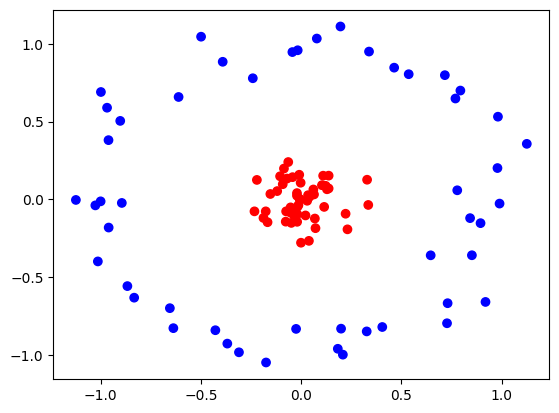

In [3]:
from matplotlib import pyplot as plt
plt.scatter(circles_data[:,0], circles_data[:,1], c=circles_data_labels, cmap='bwr')

Develope a full-connected layer to classify data

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchinfo
import torchvision.datasets as dset
from torch.utils.data import DataLoader, TensorDataset

In [5]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if train_on_gpu else 'cpu')
print(device)

CUDA is available!  Training on GPU ...
cuda


create full-connected model in pytorch

In [58]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.layer(x)
        return x

In [75]:
# standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_circles_data = scaler.fit_transform(circles_data)

# divide the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(std_circles_data, circles_data_labels, test_size=0.3)

# modify the dtype and move on to training device
X_train = (torch.tensor(X_train, dtype=torch.float32)).to(device)
X_test = (torch.tensor(X_test, dtype=torch.float32)).to(device)
Y_train = (torch.tensor(Y_train, dtype=torch.float32)).to(device)
Y_test = (torch.tensor(Y_test, dtype=torch.float32)).to(device)

# create DataLoader
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

input_dim = X_train.shape[1]
num_classes = 2

# create a model
if train_on_gpu:
    model = NN(input_size=input_dim).to(device)
else:
    model = NN(input_size=input_dim)

Epoch 5: Accuracy: 0.7571, Validation Loss: 0.5193
Epoch 10: Accuracy: 0.9571, Validation Loss: 0.3217
Epoch 15: Accuracy: 1.0000, Validation Loss: 0.1825
Epoch 20: Accuracy: 1.0000, Validation Loss: 0.0894
Epoch 25: Accuracy: 1.0000, Validation Loss: 0.0368


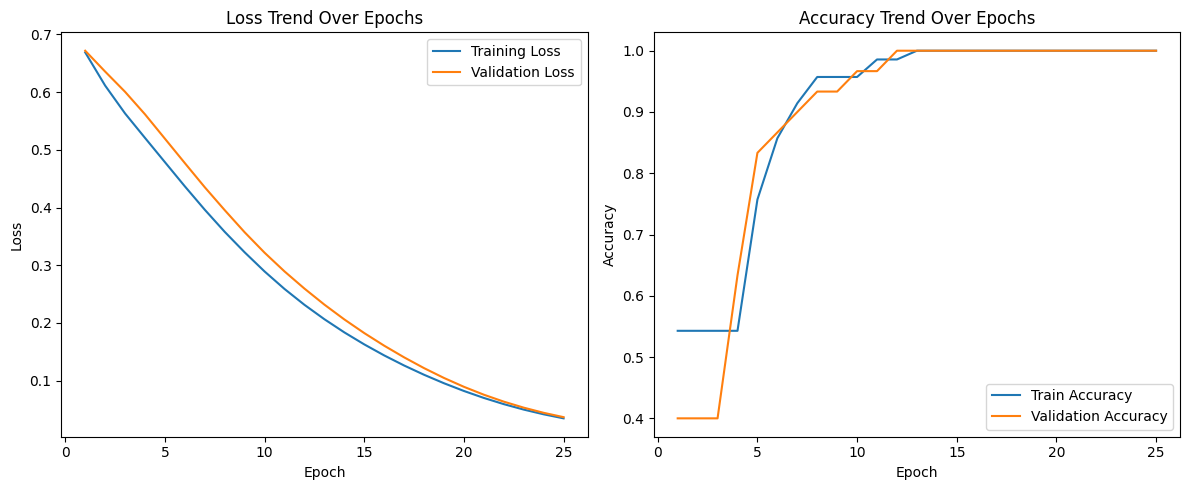

In [76]:
Epoch = 25

# loss function
loss = nn.BCELoss()
# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
valid_loss_values = []
train_accuracy_values = []
valid_accuracy_values = []

for epoch in range(1, Epoch+1):
    model.train()
    # forward pass
    Y_pred = model(X_train)
    Y_pred = Y_pred.reshape(-1)
    # compute loss
    l = loss(Y_pred, Y_train)
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    l.backward()
    # update weights
    optimizer.step()
    # calculate accuracy
    predictions = Y_pred > 0.5
    accuracy = (predictions == Y_train).sum().item() / Y_train.size(0)

    # evaluate the model
    model.eval()
    Y_pred = model(X_test)
    Y_pred = Y_pred.reshape(-1)
    valid_loss = loss(Y_pred, Y_test)
    valid_predictions = Y_pred > 0.5
    valid_acc = (valid_predictions == Y_test).sum().item() / Y_test.size(0)
    
    # store the loss and accuracy
    loss_values.append(l.item())
    valid_loss_values.append(valid_loss.item())
    train_accuracy_values.append(accuracy)
    valid_accuracy_values.append(valid_acc)
    
    # print the loss and accuracy for every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Accuracy: {accuracy:.4f}, Validation Loss: {valid_loss.item():.4f}")

# plot the loss and accuracy trends
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot the loss trend
ax[0].plot(range(1, Epoch+1), loss_values, label='Training Loss')
ax[0].plot(range(1, Epoch+1), valid_loss_values, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Trend Over Epochs')
ax[0].legend()

# plot the accuracy trend
ax[1].plot(range(1, Epoch+1), train_accuracy_values, label='Train Accuracy')
ax[1].plot(range(1, Epoch+1), valid_accuracy_values, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Trend Over Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

draw the decision boundary plot
https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron/71339#71339

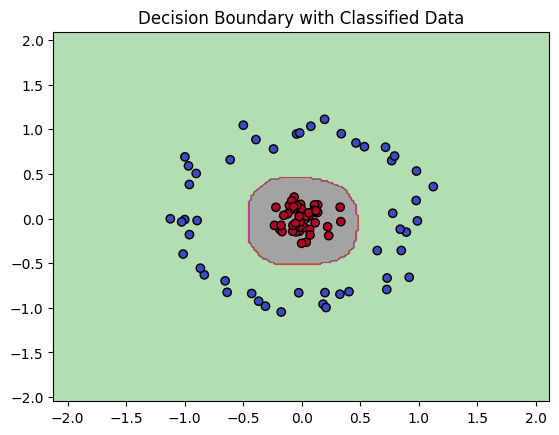

In [77]:
import numpy as np

# create a mesh to plot in
x_min, x_max = circles_data[:, 0].min() - 1, circles_data[:, 0].max() + 1
y_min, y_max = circles_data[:, 1].min() - 1, circles_data[:, 1].max() + 1
# meshgrid = make 2 np.arrays do the premutation to get a 2D array
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 按照行合併
grid_data = np.c_[xx.ravel(), yy.ravel()]
# standardize the grid data
grid_data = scaler.transform(grid_data)
# convert to tensor
grid_tensor = torch.tensor(grid_data, dtype=torch.float32).to(device)
# get the predictions
with torch.no_grad():
    result = model(grid_tensor)
    predictions = torch.round(result).cpu().numpy()  # 使用 torch.round 來取得預測結果

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
plt.contourf(xx, yy, predictions, cmap=plt.cm.Accent, alpha=0.6)
plt.scatter(circles_data[:, 0], circles_data[:, 1], c=circles_data_labels, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Decision Boundary with Classified Data")
plt.show()